In [163]:
import pandas as pd

# this first cell is computed by starting the analysis on the 70 companies we obtained before using finbert, in order to guarantee consistency with the subset of companies previous analyzed.

# STEP 1: load both datasets
df_final = pd.read_csv("final_with_ff5_and_excess_return.csv")
df_climate = pd.read_csv("climate_final_with_ff5_and_excess_return.csv")

# STEP 2: drop any existing ESG columns from the base dataset
df_final = df_final.drop(columns=['Overall_ESG_Exposure', 'Overall_ESG_Sentiment'], errors='ignore')

# STEP 3: create 'year' column for merge
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['year'] = df_final['date'].dt.year
df_climate['date'] = pd.to_datetime(df_climate['date'])
df_climate['year'] = df_climate['date'].dt.year

# STEP 4: extract ESG columns from climate dataset
df_climate_esg = df_climate[['cik', 'year', 'Overall_ESG_Exposure', 'Overall_ESG_Sentiment']].drop_duplicates()

# STEP 5: merge ESG data into the main dataset based on cik and year
df_merged = pd.merge(df_final, df_climate_esg, on=['cik', 'year'], how='left')

# STEP 6: extract ESG data for missing ticker (SO)
so_esg_data = df_climate[df_climate['TICKER'] == 'SO'][['cik', 'year', 'Overall_ESG_Exposure', 'Overall_ESG_Sentiment']].drop_duplicates()

# STEP 7: add missing ESG data for SO if not already in the merged dataset
df_merged = df_merged.merge(
    so_esg_data,
    on=['cik', 'year'],
    how='left',
    suffixes=('', '_so')
)

# fill missing ESG values from the SO-specific data
df_merged['Overall_ESG_Exposure'] = df_merged['Overall_ESG_Exposure'].fillna(df_merged['Overall_ESG_Exposure_so'])
df_merged['Overall_ESG_Sentiment'] = df_merged['Overall_ESG_Sentiment'].fillna(df_merged['Overall_ESG_Sentiment_so'])

# remove temporary columns used during the merge
df_merged = df_merged.drop(columns=['Overall_ESG_Exposure_so', 'Overall_ESG_Sentiment_so'])

# STEP 8: save the final dataset
df_merged.to_csv("final_with_full_esg_and_ff5.csv", index=False)

# STEP 9: check for any remaining missing ESG values
missing_after = df_merged[df_merged['Overall_ESG_Exposure'].isna()]

df_merged


,TICKER,date,Overall_ESG_Score,Macro_Sector,SIC,cik,Mkt-RF,SMB,HML,RMW,CMA,excess_RET,year,Overall_ESG_Exposure,Overall_ESG_Sentiment
0,KO,2019-03-29,0.032480,Industrials,2086,21344,0.0110,-0.0351,-0.0412,0.0091,-0.0094,0.040447,2019,0.340771,0.133088
1,KO,2019-04-30,0.032480,Industrials,2086,21344,0.0397,-0.0115,0.0216,0.0159,-0.0222,0.044848,2019,0.340771,0.133088
2,KO,2019-05-31,0.032480,Industrials,2086,21344,-0.0694,-0.0159,-0.0237,-0.0046,0.0177,-0.000673,2019,0.340771,0.133088
3,KO,2019-06-28,0.032480,Industrials,2086,21344,0.0693,0.0037,-0.0070,0.0090,-0.0044,0.042776,2019,0.340771,0.133088
4,KO,2019-07-31,0.032480,Industrials,2086,21344,0.0119,-0.0178,0.0047,-0.0007,0.0034,0.031682,2019,0.340771,0.133088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,FTNT,2024-08-30,0.039986,Industrials,3577,1262039,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.316875,2024,0.031968,0.385596
4896,FTNT,2024-09-30,0.039986,Industrials,3577,1262039,0.0174,-0.0102,-0.0259,0.0004,-0.0026,0.006950,2024,0.031968,0.385596
4897,FTNT,2024-10-31,0.039986,Industrials,3577,1262039,-0.0097,-0.0088,0.0089,-0.0138,0.0103,0.010413,2024,0.031968,0.385596
4898,FTNT,2024-11-29,0.039986,Industrials,3577,1262039,0.0651,0.0478,-0.0005,-0.0262,-0.0217,0.204365,2024,0.031968,0.385596


In [165]:
import pandas as pd
import statsmodels.api as sm

#FF_5_regressions

# 1. prepare the regression
regression_results_nw = []
tickers = df_merged['TICKER'].unique()

# 2. loop for each company
for ticker in tickers:
    data = df_merged[df_merged['TICKER'] == ticker].dropna(
        subset=['excess_RET', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    ).sort_values(by='date')  #  order by date

    if len(data) >= 12:
        X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
        y = data['excess_RET']
        X = sm.add_constant(X)

        # 4. Regression with HAC (Newey-West)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # 5. save results
        regression_results_nw.append({
            'TICKER': ticker,
            'Macro_Sector': data['Macro_Sector'].iloc[0],
            'Alpha': model.params['const'],
            'Beta_MktRF': model.params['Mkt-RF'],
            'Beta_SMB': model.params['SMB'],
            'Beta_HML': model.params['HML'],
            'Beta_RMW': model.params['RMW'],
            'Beta_CMA': model.params['CMA'],
            'T_Alpha': model.tvalues['const'],
            'T_Beta_MktRF': model.tvalues['Mkt-RF'],
            'T_Beta_SMB': model.tvalues['SMB'],
            'T_Beta_HML': model.tvalues['HML'],
            'T_Beta_RMW': model.tvalues['RMW'],
            'T_Beta_CMA': model.tvalues['CMA'],
            'P_Alpha': model.pvalues['const'],
            'P_Beta_MktRF': model.pvalues['Mkt-RF'],
            'P_Beta_SMB': model.pvalues['SMB'],
            'P_Beta_HML': model.pvalues['HML'],
            'P_Beta_RMW': model.pvalues['RMW'],
            'P_Beta_CMA': model.pvalues['CMA'],
            'Beta_MktRF_Significant': model.pvalues['Mkt-RF'] < 0.05,
            'Beta_SMB_Significant': model.pvalues['SMB'] < 0.05,
            'Beta_HML_Significant': model.pvalues['HML'] < 0.05,
            'Beta_RMW_Significant': model.pvalues['RMW'] < 0.05,
            'Beta_CMA_Significant': model.pvalues['CMA'] < 0.05,
            'Alpha_Significant': model.pvalues['const'] < 0.05,
            'Adj_R_squared': model.rsquared_adj,
            'R_squared': model.rsquared,
            'Num_Obs': int(model.nobs)
        })

# 3. converte in DataFrame
regression_df_nw = pd.DataFrame(regression_results_nw)

# 4. save
regression_df_nw.to_csv("1147_climate_dataset_fama_french_5_regression_results.csv", index=False)

regression_df_nw


,TICKER,Macro_Sector,Alpha,Beta_MktRF,Beta_SMB,Beta_HML,Beta_RMW,Beta_CMA,T_Alpha,T_Beta_MktRF,...,P_Beta_CMA,Beta_MktRF_Significant,Beta_SMB_Significant,Beta_HML_Significant,Beta_RMW_Significant,Beta_CMA_Significant,Alpha_Significant,Adj_R_squared,R_squared,Num_Obs
0,KO,Industrials,-0.003529,0.578984,-0.302095,0.223039,0.511523,0.181469,-0.800137,4.903909,...,0.461901,True,False,False,True,False,False,0.439657,0.480262,70
1,CDNS,Consumer,0.012936,1.053079,-0.216166,-0.469884,-0.003907,-0.525707,1.962976,9.261980,...,0.092902,True,False,True,False,False,True,0.593216,0.622693,70
2,XRAY,Industrials,-0.019105,0.793059,0.655076,-0.056551,0.614543,0.545420,-1.997983,5.212740,...,0.129605,True,True,False,False,False,True,0.303729,0.354184,70
3,CHTR,Industrials,-0.009544,0.856661,0.694679,-0.016294,0.827288,0.005565,-0.868475,3.781553,...,0.991885,True,False,False,False,False,False,0.276188,0.328639,70
4,GM,Industrials,-0.002130,1.309919,0.621259,0.432944,-0.102425,-0.017406,-0.261884,7.393655,...,0.973445,True,False,False,False,False,False,0.517744,0.552690,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CF,Industrials,0.008442,0.985553,0.521015,0.542672,-0.336669,0.625838,0.834997,3.584789,...,0.327697,True,False,False,False,False,False,0.397397,0.441064,70
66,UAL,Industrials,0.002112,1.265851,0.387025,1.310629,-0.601031,-0.548295,0.132963,5.557704,...,0.443769,True,False,True,False,False,False,0.387737,0.432104,70
67,ROST,Consumer,-0.003194,1.022573,0.061942,0.082968,0.193343,0.002254,-0.445007,6.113492,...,0.995767,True,False,False,False,False,False,0.387964,0.432314,70
68,PM,Industrials,0.001330,0.589634,-0.008293,0.339404,0.252224,0.513998,0.241064,4.130783,...,0.025377,True,False,False,False,True,False,0.392351,0.436383,70


In [167]:
sector_stats = regression_df_nw.groupby('Macro_Sector').agg(
    Alpha_mean=('Alpha', 'mean'),
    Alpha_std=('Alpha', 'std'),
    Beta_MktRF_mean=('Beta_MktRF', 'mean'),
    Beta_MktRF_std=('Beta_MktRF', 'std'),
    Beta_SMB_mean=('Beta_SMB', 'mean'),
    Beta_SMB_std=('Beta_SMB', 'std'),
    Beta_HML_mean=('Beta_HML', 'mean'),
    Beta_HML_std=('Beta_HML', 'std'),
    Beta_RMW_mean=('Beta_RMW', 'mean'),
    Beta_RMW_std=('Beta_RMW', 'std'),
    Beta_CMA_mean=('Beta_CMA', 'mean'),
    Beta_CMA_std=('Beta_CMA', 'std'),
    N_Companies=('TICKER', 'nunique'),
    R_squared_mean=('R_squared', 'mean'),
    Adj_R_squared_mean=('Adj_R_squared', 'mean'),
).reset_index()

sector_stats.to_csv("1147climate_new_ff5_industrial_stats.csv", index=False)
sector_stats



,Macro_Sector,Alpha_mean,Alpha_std,Beta_MktRF_mean,Beta_MktRF_std,Beta_SMB_mean,Beta_SMB_std,Beta_HML_mean,Beta_HML_std,Beta_RMW_mean,Beta_RMW_std,Beta_CMA_mean,Beta_CMA_std,N_Companies,R_squared_mean,Adj_R_squared_mean
0,Consumer,-0.003230,0.008744,1.090252,0.311789,0.246763,0.579208,0.019597,0.418495,0.233648,0.390645,0.001460,0.452770,20,0.469887,0.428472
1,Energy & Utilities,-0.002879,0.003523,0.760580,0.369420,-0.126710,0.231320,0.239059,0.477164,0.180514,0.270769,0.382917,0.256788,14,0.368783,0.319469
2,Industrials,-0.002781,0.008759,0.954257,0.476892,0.191185,0.458038,0.119248,0.529317,0.231886,0.540026,0.132967,0.473537,36,0.446305,0.403048


In [169]:
import pandas as pd
import statsmodels.api as sm

#FF_5_regressions + esg

# 1. prepare the regression
regression_results_nw_climate= []
tickers = df_merged['TICKER'].unique()

# 2. loop for each company
for ticker in tickers:
    data = df_merged[df_merged['TICKER'] == ticker].dropna(
        subset=['excess_RET', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Overall_ESG_Exposure','Overall_ESG_Sentiment']
    ).sort_values(by='date')  #  order by date

    if len(data) >= 12:
        X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA','Overall_ESG_Exposure','Overall_ESG_Sentiment']]
        y = data['excess_RET']
        X = sm.add_constant(X)

        # 4. Regression with HAC (Newey-West)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # 5. save results
        regression_results_nw_climate.append({
            'TICKER': ticker,
            'Macro_Sector': data['Macro_Sector'].iloc[0],
            'Alpha': model.params['const'],
            'Beta_MktRF': model.params['Mkt-RF'],
            'Beta_SMB': model.params['SMB'],
            'Beta_HML': model.params['HML'],
            'Beta_RMW': model.params['RMW'],
            'Beta_CMA': model.params['CMA'],
            'Beta_Overall_ESG_Exposure': model.params['Overall_ESG_Exposure'],
            'Beta_Overall_ESG_Sentiment': model.params['Overall_ESG_Sentiment'],
            'T_Alpha': model.tvalues['const'],
            'T_Beta_MktRF': model.tvalues['Mkt-RF'],
            'T_Beta_SMB': model.tvalues['SMB'],
            'T_Beta_HML': model.tvalues['HML'],
            'T_Beta_RMW': model.tvalues['RMW'],
            'T_Beta_CMA': model.tvalues['CMA'],
            'T_Beta_Overall_ESG_Exposure': model.tvalues['Overall_ESG_Exposure'],
            'T_Beta_Overall_ESG_Sentiment': model.tvalues['Overall_ESG_Sentiment'],
            'P_Alpha': model.pvalues['const'],
            'P_Beta_MktRF': model.pvalues['Mkt-RF'],
            'P_Beta_SMB': model.pvalues['SMB'],
            'P_Beta_HML': model.pvalues['HML'],
            'P_Beta_RMW': model.pvalues['RMW'],
            'P_Beta_CMA': model.pvalues['CMA'],
            'P_Beta_Overall_ESG_Exposure': model.pvalues['Overall_ESG_Exposure'],
            'P_Beta_Overall_ESG_Sentiment': model.pvalues['Overall_ESG_Sentiment'],
            'Beta_MktRF_Significant': model.pvalues['Mkt-RF'] < 0.05,
            'Beta_SMB_Significant': model.pvalues['SMB'] < 0.05,
            'Beta_HML_Significant': model.pvalues['HML'] < 0.05,
            'Beta_RMW_Significant': model.pvalues['RMW'] < 0.05,
            'Beta_CMA_Significant': model.pvalues['CMA'] < 0.05,
            'Beta_Overall_ESG_Exposure_Significant': model.pvalues['Overall_ESG_Exposure'] < 0.05,
            'Beta_Overall_ESG_Sentiment_Significant': model.pvalues['Overall_ESG_Sentiment'] < 0.05,
            'Alpha_Significant': model.pvalues['const'] < 0.05,
            'Adj_R_squared': model.rsquared_adj,
            'R_squared': model.rsquared,
            'Num_Obs': int(model.nobs)
        })

# 3. converte in DataFrame
regression_df_nw_climate = pd.DataFrame(regression_results_nw_climate)

# 4. save
regression_df_nw_climate.to_csv("1147_climate_dataset_fama_french_5esg_regression_results.csv", index=False)

regression_df_nw_climate


,TICKER,Macro_Sector,Alpha,Beta_MktRF,Beta_SMB,Beta_HML,Beta_RMW,Beta_CMA,Beta_Overall_ESG_Exposure,Beta_Overall_ESG_Sentiment,...,Beta_SMB_Significant,Beta_HML_Significant,Beta_RMW_Significant,Beta_CMA_Significant,Beta_Overall_ESG_Exposure_Significant,Beta_Overall_ESG_Sentiment_Significant,Alpha_Significant,Adj_R_squared,R_squared,Num_Obs
0,KO,Industrials,0.028272,0.574910,-0.331919,0.273551,0.507372,0.104948,0.010482,-0.167893,...,False,False,True,False,False,False,False,0.443517,0.499972,70
1,CDNS,Consumer,0.126101,1.093289,-0.348394,-0.408581,-0.148019,-0.765605,-4.021363,-0.257537,...,False,True,False,True,True,True,True,0.623718,0.661891,70
2,XRAY,Industrials,-0.051953,0.768261,0.591281,0.038661,0.571363,0.455263,1.487205,-0.027233,...,True,False,False,False,False,False,False,0.294258,0.365855,70
3,CHTR,Industrials,-0.008351,0.813287,0.608594,0.196050,0.923869,-0.067277,3.538793,-0.142588,...,False,False,True,False,False,False,False,0.291871,0.363710,70
4,GM,Industrials,0.029330,1.285599,0.564129,0.518998,-0.125201,-0.048781,-0.720985,0.185284,...,False,False,False,False,False,False,False,0.516882,0.565894,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,CF,Industrials,0.079187,0.982756,0.545314,0.506931,-0.345810,0.669055,-0.104757,-0.136558,...,False,False,False,False,False,False,False,0.379908,0.442816,70
65,UAL,Industrials,0.054409,1.309221,0.619407,1.041942,-0.472703,-0.372348,0.297124,-0.308200,...,False,True,False,False,False,False,False,0.393479,0.455010,70
66,ROST,Consumer,0.008732,1.014621,0.075949,0.093321,0.215767,-0.011341,0.259125,-0.035963,...,False,False,False,False,False,False,False,0.372110,0.435809,70
67,PM,Industrials,-0.134496,0.566590,0.005992,0.358939,0.267703,0.530867,0.369492,0.262021,...,False,False,False,True,False,False,False,0.382198,0.444873,70


In [171]:
sector_stats_climate = regression_df_nw_climate.groupby('Macro_Sector').agg(
    Alpha_mean=('Alpha', 'mean'),
    Alpha_std=('Alpha', 'std'),
    Beta_MktRF_mean=('Beta_MktRF', 'mean'),
    Beta_MktRF_std=('Beta_MktRF', 'std'),
    Beta_SMB_mean=('Beta_SMB', 'mean'),
    Beta_SMB_std=('Beta_SMB', 'std'),
    Beta_HML_mean=('Beta_HML', 'mean'),
    Beta_HML_std=('Beta_HML', 'std'),
    Beta_RMW_mean=('Beta_RMW', 'mean'),
    Beta_RMW_std=('Beta_RMW', 'std'),
    Beta_CMA_mean=('Beta_CMA', 'mean'),
    Beta_CMA_std=('Beta_CMA', 'std'),
    Beta_Overall_ESG_Exposure_mean = ('Beta_Overall_ESG_Exposure', 'mean'),
    Beta_Overall_ESG_Exposure_std = ('Beta_Overall_ESG_Exposure', 'std'),
    Beta_Overall_ESG_Sentiment_mean = ('Beta_Overall_ESG_Sentiment', 'mean'),
    Beta_Overall_ESG_Sentiment_std = ('Beta_Overall_ESG_Sentiment', 'std'),
    N_Companies=('TICKER', 'nunique'),
    R_squared_mean=('R_squared', 'mean'),
    Adj_R_squared_mean=('Adj_R_squared', 'mean'),
).reset_index()

sector_stats_climate.to_csv("1147climate_new_ff5esg_industrial_stats.csv", index=False)
sector_stats_climate



,Macro_Sector,Alpha_mean,Alpha_std,Beta_MktRF_mean,Beta_MktRF_std,Beta_SMB_mean,Beta_SMB_std,Beta_HML_mean,Beta_HML_std,Beta_RMW_mean,Beta_RMW_std,Beta_CMA_mean,Beta_CMA_std,Beta_Overall_ESG_Exposure_mean,Beta_Overall_ESG_Exposure_std,Beta_Overall_ESG_Sentiment_mean,Beta_Overall_ESG_Sentiment_std,N_Companies,R_squared_mean,Adj_R_squared_mean
0,Consumer,-0.005169,0.088383,1.095996,0.313365,0.206540,0.572468,0.049405,0.402473,0.194038,0.402202,-0.074079,0.493312,0.260197,2.705070,-0.007863,0.175542,20,0.483768,0.425483
1,Energy & Utilities,-0.046028,0.112315,0.789253,0.385641,-0.103922,0.199119,0.240772,0.503447,0.181087,0.321781,0.350778,0.203081,1.021079,3.483942,0.041914,0.278083,13,0.392295,0.323683
2,Industrials,0.003204,0.056891,0.949839,0.471561,0.185883,0.446326,0.138818,0.495508,0.243008,0.521229,0.121352,0.454312,-0.099159,3.466022,-0.058250,0.161515,36,0.466861,0.406668


In [173]:
import pandas as pd
import statsmodels.api as sm

#FF_3_regressions

# 1. prepare the regression
regression_results_nw_ff3 = []
tickers = df_merged['TICKER'].unique()

# 2. loop for each company
for ticker in tickers:
    data = df_merged[df_merged['TICKER'] == ticker].dropna(
        subset=['excess_RET', 'Mkt-RF', 'SMB', 'HML']
    ).sort_values(by='date')  #  order by date

    if len(data) >= 12:
        X = data[['Mkt-RF', 'SMB', 'HML']]
        y = data['excess_RET']
        X = sm.add_constant(X)

        # 4. Regression with HAC (Newey-West)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # 5. save results
        regression_results_nw_ff3.append({
            'TICKER': ticker,
            'Macro_Sector': data['Macro_Sector'].iloc[0],
            'Alpha': model.params['const'],
            'Beta_MktRF': model.params['Mkt-RF'],
            'Beta_SMB': model.params['SMB'],
            'Beta_HML': model.params['HML'],
            'T_Alpha': model.tvalues['const'],
            'T_Beta_MktRF': model.tvalues['Mkt-RF'],
            'T_Beta_SMB': model.tvalues['SMB'],
            'T_Beta_HML': model.tvalues['HML'],
            'P_Alpha': model.pvalues['const'],
            'P_Beta_MktRF': model.pvalues['Mkt-RF'],
            'P_Beta_SMB': model.pvalues['SMB'],
            'P_Beta_HML': model.pvalues['HML'],
            'Beta_MktRF_Significant': model.pvalues['Mkt-RF'] < 0.05,
            'Beta_SMB_Significant': model.pvalues['SMB'] < 0.05,
            'Beta_HML_Significant': model.pvalues['HML'] < 0.05,
            'Alpha_Significant': model.pvalues['const'] < 0.05,
            'Adj_R_squared': model.rsquared_adj,
            'R_squared': model.rsquared,
            'Num_Obs': int(model.nobs)
        })

# 3. converte in DataFrame
regression_df_nw_ff3= pd.DataFrame(regression_results_nw_ff3)

# 4. save
regression_df_nw_ff3.to_csv("1147_climate_dataset_fama_french_3_regression_results.csv", index=False)

regression_df_nw_ff3


,TICKER,Macro_Sector,Alpha,Beta_MktRF,Beta_SMB,Beta_HML,T_Alpha,T_Beta_MktRF,T_Beta_SMB,T_Beta_HML,...,P_Beta_MktRF,P_Beta_SMB,P_Beta_HML,Beta_MktRF_Significant,Beta_SMB_Significant,Beta_HML_Significant,Alpha_Significant,Adj_R_squared,R_squared,Num_Obs
0,KO,Industrials,-0.001381,0.619260,-0.566814,0.416337,-0.282850,5.069805,-3.408864,3.769152,...,3.982245e-07,0.000652,1.638033e-04,True,True,True,False,0.409313,0.434995,70
1,CDNS,Consumer,0.012187,1.103777,-0.120148,-0.716078,1.843828,9.427286,-0.570368,-6.115036,...,4.208385e-21,0.568428,9.653538e-10,True,False,True,False,0.589017,0.606886,70
2,XRAY,Industrials,-0.016067,0.809597,0.278348,0.328487,-1.650329,6.063373,0.874264,1.848708,...,1.332960e-09,0.381974,6.450005e-02,True,False,False,False,0.290413,0.321265,70
3,CHTR,Industrials,-0.006471,0.949808,0.318165,0.161945,-0.599439,4.418677,0.732049,0.703064,...,9.930670e-06,0.464139,4.820159e-01,True,False,False,False,0.268683,0.300479,70
4,GM,Industrials,-0.002534,1.300013,0.670871,0.403074,-0.316951,7.901401,1.842189,3.280986,...,2.757858e-15,0.065448,1.034447e-03,True,False,True,False,0.531985,0.552333,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CF,Industrials,0.008069,0.886545,0.561638,0.763292,0.804421,3.878881,2.405098,4.528186,...,1.049379e-04,0.016168,5.949212e-06,True,True,True,False,0.396946,0.423166,70
66,UAL,Industrials,-0.000881,1.251122,0.758136,0.927118,-0.058258,5.909736,1.691927,3.174615,...,3.426573e-09,0.090660,1.500354e-03,True,False,True,False,0.393729,0.420088,70
67,ROST,Consumer,-0.002474,1.044249,-0.026223,0.125068,-0.338145,7.103823,-0.110686,0.723568,...,1.213520e-12,0.911865,4.693308e-01,True,False,False,False,0.404159,0.430065,70
68,PM,Industrials,0.002982,0.568197,-0.214927,0.632853,0.502951,4.118666,-1.293051,4.984985,...,3.810713e-05,0.195993,6.196663e-07,True,False,True,False,0.377077,0.404161,70


In [175]:
sector_stats_ff3 = regression_df_nw_ff3.groupby('Macro_Sector').agg(
    Alpha_mean=('Alpha', 'mean'),
    Alpha_std=('Alpha', 'std'),
    Beta_MktRF_mean=('Beta_MktRF', 'mean'),
    Beta_MktRF_std=('Beta_MktRF', 'std'),
    Beta_SMB_mean=('Beta_SMB', 'mean'),
    Beta_SMB_std=('Beta_SMB', 'std'),
    Beta_HML_mean=('Beta_HML', 'mean'),
    Beta_HML_std=('Beta_HML', 'std'),
    N_Companies=('TICKER', 'nunique'),
    R_squared_mean=('R_squared', 'mean'),
    Adj_R_squared_mean=('Adj_R_squared', 'mean'),
).reset_index()

sector_stats_ff3.to_csv("1147climate_new_ff3_industrial_stats.csv", index=False)
sector_stats_ff3



,Macro_Sector,Alpha_mean,Alpha_std,Beta_MktRF_mean,Beta_MktRF_std,Beta_SMB_mean,Beta_SMB_std,Beta_HML_mean,Beta_HML_std,N_Companies,R_squared_mean,Adj_R_squared_mean
0,Consumer,-0.002362,0.007849,1.116570,0.339929,0.140445,0.540080,0.069884,0.380069,20,0.450603,0.425630
1,Energy & Utilities,-0.001676,0.003336,0.743773,0.350755,-0.277295,0.275301,0.456103,0.453882,14,0.344706,0.314920
2,Industrials,-0.001736,0.007815,0.967583,0.489624,0.062092,0.465981,0.230540,0.365245,36,0.410750,0.383966


In [177]:
import pandas as pd
import statsmodels.api as sm

#FF_3_regressions + esg

# 1. prepare the regression
regression_results_nw_ff3 = []
tickers = df_merged['TICKER'].unique()

# 2. loop for each company
for ticker in tickers:
    data = df_merged[df_merged['TICKER'] == ticker].dropna(
        subset=['excess_RET', 'Mkt-RF', 'SMB', 'HML', 'Overall_ESG_Exposure','Overall_ESG_Sentiment']
    ).sort_values(by='date')  #  order by date

    if len(data) >= 12:
        X = data[['Mkt-RF', 'SMB', 'HML', 'Overall_ESG_Exposure','Overall_ESG_Sentiment']]
        y = data['excess_RET']
        X = sm.add_constant(X)

        # 4. Regression with HAC (Newey-West)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

        # 5. save results
        regression_results_nw_ff3.append({
            'TICKER': ticker,
            'Macro_Sector': data['Macro_Sector'].iloc[0],
            'Alpha': model.params['const'],
            'Beta_MktRF': model.params['Mkt-RF'],
            'Beta_SMB': model.params['SMB'],
            'Beta_HML': model.params['HML'],
            'Beta_Overall_ESG_Exposure': model.params['Overall_ESG_Exposure'],
            'Beta_Overall_ESG_Sentiment': model.params['Overall_ESG_Sentiment'],
            'T_Alpha': model.tvalues['const'],
            'T_Beta_MktRF': model.tvalues['Mkt-RF'],
            'T_Beta_SMB': model.tvalues['SMB'],
            'T_Beta_HML': model.tvalues['HML'],
            'T_Beta_Overall_ESG_Exposure': model.tvalues['Overall_ESG_Exposure'],
            'T_Beta_Overall_ESG_Sentiment': model.tvalues['Overall_ESG_Sentiment'],
            'P_Alpha': model.pvalues['const'],
            'P_Beta_MktRF': model.pvalues['Mkt-RF'],
            'P_Beta_SMB': model.pvalues['SMB'],
            'P_Beta_HML': model.pvalues['HML'],
            'P_Beta_Overall_ESG_Exposure': model.pvalues['Overall_ESG_Exposure'],
            'P_Beta_Overall_ESG_Sentiment': model.pvalues['Overall_ESG_Sentiment'],
            'Beta_MktRF_Significant': model.pvalues['Mkt-RF'] < 0.05,
            'Beta_SMB_Significant': model.pvalues['SMB'] < 0.05,
            'Beta_HML_Significant': model.pvalues['HML'] < 0.05,
            'Beta_Overall_ESG_Exposure_Significant': model.pvalues['Overall_ESG_Exposure'] < 0.05,
            'Beta_Overall_ESG_Sentiment_Significant': model.pvalues['Overall_ESG_Sentiment'] < 0.05,
            'Alpha_Significant': model.pvalues['const'] < 0.05,
            'Adj_R_squared': model.rsquared_adj,
            'R_squared': model.rsquared,
            'Num_Obs': int(model.nobs)
        })

# 3. converte in DataFrame
regression_df_nw_ff3= pd.DataFrame(regression_results_nw_ff3)

# 4. save
regression_df_nw_ff3.to_csv("1147_climate_dataset_fama_french_3esg_regression_results.csv", index=False)

regression_df_nw_ff3


,TICKER,Macro_Sector,Alpha,Beta_MktRF,Beta_SMB,Beta_HML,Beta_Overall_ESG_Exposure,Beta_Overall_ESG_Sentiment,T_Alpha,T_Beta_MktRF,...,P_Beta_Overall_ESG_Sentiment,Beta_MktRF_Significant,Beta_SMB_Significant,Beta_HML_Significant,Beta_Overall_ESG_Exposure_Significant,Beta_Overall_ESG_Sentiment_Significant,Alpha_Significant,Adj_R_squared,R_squared,Num_Obs
0,KO,Industrials,0.007940,0.627547,-0.583633,0.419515,0.042252,-0.096211,0.209060,5.279789,...,0.511658,True,True,True,False,False,False,0.417763,0.459954,70
1,CDNS,Consumer,0.093805,1.132462,-0.134178,-0.779023,-3.174189,-0.149363,2.392480,8.919626,...,0.295479,True,False,True,True,False,True,0.602532,0.631334,70
2,XRAY,Industrials,-0.043170,0.791621,0.245011,0.372519,1.671160,-0.059895,-0.680941,6.401654,...,0.607495,True,False,False,False,False,False,0.289433,0.340923,70
3,CHTR,Industrials,-0.013505,0.929722,0.215869,0.332505,3.306811,-0.109316,-0.169475,4.532143,...,0.517174,True,False,False,False,False,False,0.276274,0.328718,70
4,GM,Industrials,0.022758,1.276758,0.630336,0.469721,-0.678238,0.189084,0.232830,7.791778,...,0.193272,True,False,True,False,False,False,0.531367,0.565326,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,CF,Industrials,-0.010132,0.891464,0.568034,0.753091,0.115715,-0.106630,-0.047256,3.709902,...,0.641409,True,True,True,False,False,False,0.379210,0.424194,70
65,UAL,Industrials,0.057651,1.297259,0.911230,0.756253,0.313506,-0.334642,1.572856,6.614652,...,0.099217,True,True,True,False,False,False,0.405548,0.448624,70
66,ROST,Consumer,0.012574,1.042027,-0.021762,0.130360,0.057494,-0.032108,0.294767,6.868222,...,0.295843,True,False,False,False,False,False,0.388790,0.433081,70
67,PM,Industrials,-0.115917,0.548948,-0.209563,0.655972,0.298155,0.234775,-0.754689,3.708034,...,0.503833,True,False,True,False,False,False,0.364285,0.410352,70


In [179]:
sector_stats_ff3_climate = regression_df_nw_ff3.groupby('Macro_Sector').agg(
    Alpha_mean=('Alpha', 'mean'),
    Alpha_std=('Alpha', 'std'),
    Beta_MktRF_mean=('Beta_MktRF', 'mean'),
    Beta_MktRF_std=('Beta_MktRF', 'std'),
    Beta_SMB_mean=('Beta_SMB', 'mean'),
    Beta_SMB_std=('Beta_SMB', 'std'),
    Beta_HML_mean=('Beta_HML', 'mean'),
    Beta_HML_std=('Beta_HML', 'std'),
    Beta_Overall_ESG_Exposure_mean = ('Beta_Overall_ESG_Exposure', 'mean'),
    Beta_Overall_ESG_Exposure_std = ('Beta_Overall_ESG_Exposure', 'std'),
    Beta_Overall_ESG_Sentiment_mean = ('Beta_Overall_ESG_Sentiment', 'mean'),
    Beta_Overall_ESG_Sentiment_std = ('Beta_Overall_ESG_Sentiment', 'std'),
    N_Companies=('TICKER', 'nunique'),
    R_squared_mean=('R_squared', 'mean'),
    Adj_R_squared_mean=('Adj_R_squared', 'mean'),
).reset_index()

sector_stats_ff3_climate.to_csv("1147climate_new_ff3esg_industrial_stats.csv", index=False)
sector_stats_ff3_climate


,Macro_Sector,Alpha_mean,Alpha_std,Beta_MktRF_mean,Beta_MktRF_std,Beta_SMB_mean,Beta_SMB_std,Beta_HML_mean,Beta_HML_std,Beta_Overall_ESG_Exposure_mean,Beta_Overall_ESG_Exposure_std,Beta_Overall_ESG_Sentiment_mean,Beta_Overall_ESG_Sentiment_std,N_Companies,R_squared_mean,Adj_R_squared_mean
0,Consumer,-0.007623,0.092325,1.124782,0.339495,0.133624,0.542179,0.053452,0.380834,0.356801,2.845937,0.011869,0.170614,20,0.464102,0.422235
1,Energy & Utilities,-0.046197,0.116045,0.777518,0.369691,-0.253153,0.272865,0.442003,0.470635,1.022738,3.441730,0.021384,0.289945,13,0.368850,0.319541
2,Industrials,0.002302,0.056373,0.968199,0.477462,0.052457,0.472784,0.243344,0.390187,-0.064162,3.609492,-0.061200,0.166702,36,0.433952,0.389729


In [181]:
import pandas as pd

# LOADING ESG - CLIMATE FILES

# paths of climate_ESG files from 2018 to 2023
file_paths_climate = {
    2018: "Climatebert_10K_filings_2018_with_SIC_filtered.csv",
    2019: "Climatebert_10K_filings_2019_with_SIC_filtered.csv",
    2020: "Climatebert_10K_filings_2020_with_SIC_filtered.csv",
    2021: "Climatebert_10K_filings_2021_with_SIC_filtered.csv",
    2022: "Climatebert_10K_filings_2022_with_SIC_filtered.csv",
    2023: "Climatebert_10K_filings_2023_with_SIC_filtered.csv"
}

# step 1: upload the CIK from each year
cik_sets = {}
for year, path in file_paths_climate.items():
    df = pd.read_csv(path)
    df['cik_str'] = df['cik'].astype(str).str.zfill(10)
    cik_sets[year] = set(df['cik_str'].dropna().unique())

# step 2: Find the companies present in all years (intersection between all sets)
common_cik_strs = set.intersection(*cik_sets.values())

# step 3: Upload files and filter only common companies
esg_dfs = []
for year, path in file_paths_climate.items():
    df = pd.read_csv(path)
    df['cik_str'] = df['cik'].astype(str).str.zfill(10)
    df['year'] = year
    df_filtered = df[df['cik_str'].isin(common_cik_strs)].copy()
    esg_dfs.append(df_filtered)

# step 4: Merge everything into one DataFrame
esg_climatebert = pd.concat(esg_dfs, ignore_index=True)

# step 5: order and visualize
esg_climatebert.sort_values(['cik_str', 'year'], inplace=True)
print(f"Panel ESG: {esg_climatebert.shape[0]} rows for {esg_climatebert['cik_str'].nunique()} companies")
esg_climatebert


Panel ESG: 481 rows for 80 companies


,year,company,cik,SIC,Item_1_ESG_Exposure,Item_1_ESG_Sentiment,Item_1A_ESG_Exposure,Item_1A_ESG_Sentiment,Item_7_ESG_Exposure,Item_7_ESG_Sentiment,Item_8_ESG_Exposure,Item_8_ESG_Sentiment,Overall_ESG_Exposure,Overall_ESG_Sentiment,cik_str
0,2018,ABBOTT LABORATORIES,1800,2834,0.061404,0.439266,0.015504,0.970271,0.015748,0.289263,0.020173,0.203037,0.028207,0.475459,0000001800
80,2019,ABBOTT LABORATORIES,1800,2834,0.079545,0.408241,0.029304,0.970723,0.016082,0.311016,0.021932,0.270182,0.036716,0.490040,0000001800
160,2020,ABBOTT LABORATORIES,1800,2834,0.065868,0.444568,0.029412,0.939335,0.016575,0.431361,0.018429,0.423123,0.032571,0.559597,0000001800
240,2021,ABBOTT LABORATORIES,1800,2834,0.000000,0.000000,0.028239,0.641363,0.015274,0.495797,0.017199,0.412893,0.015178,0.387513,0000001800
320,2022,ABBOTT LABORATORIES,1800,2834,0.053691,0.293718,0.025000,0.948349,0.013793,0.586694,0.015695,0.330586,0.027045,0.539837,0000001800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2019,"Evergy, Inc.",1711269,4931,0.000000,0.000000,0.388298,0.605831,0.500000,-0.066984,0.000000,0.000000,0.222074,0.134712,0001711269
188,2020,"Evergy, Inc.",1711269,4931,0.000000,0.000000,0.263374,0.561510,1.000000,0.156056,0.000000,0.000000,0.315844,0.179391,0001711269
268,2021,"Evergy, Inc.",1711269,4931,0.000000,0.000000,0.263736,0.517503,0.230769,0.173337,0.000000,0.000000,0.123626,0.172710,0001711269
348,2022,"Evergy, Inc.",1711269,4931,0.381443,-0.051392,0.288732,0.536463,0.187713,0.304676,0.128806,0.278100,0.246674,0.266962,0001711269


In [183]:
import pandas as pd

# step 1: exclude financial firms (SIC between 6000 and 6999)
esg_climate= esg_climatebert[~esg_climatebert['SIC'].between(6000, 6999)].copy()

# step 2: classify Industry and Macro_Sector
def classify_industry(sic):
    if 1 <= sic <= 999:
        return "Agriculture"
    elif 1000 <= sic <= 1499:
        return "Mining"
    elif 1500 <= sic <= 1799:
        return "Construction"
    elif 2000 <= sic <= 3999:
        return "Manufacturing"
    elif 4000 <= sic <= 4899:
        return "Transportation"
    elif 4900 <= sic <= 4999:
        return "Utilities"
    elif 5000 <= sic <= 5199:
        return "Wholesale"
    elif 5200 <= sic <= 5999:
        return "Retail"
    elif 6000 <= sic <= 6799:
        return "Finance"
    elif 7000 <= sic <= 8999:
        return "Services"
    elif 9000 <= sic <= 9999:
        return "Public"
    else:
        return "Missing"

def assign_macro_sector(industry):
    if industry in ['Manufacturing', 'Transportation']:
        return 'Industrials'
    elif industry in ['Retail', 'Services']:
        return 'Consumer'
    elif industry in ['Utilities', 'Mining']:
        return 'Energy & Utilities'
    else:
        return 'Other'

# apply classifications
esg_climate['Industry'] = esg_climate['SIC'].apply(classify_industry)
esg_climate['Macro_Sector'] = esg_climate['Industry'].apply(assign_macro_sector)

# Sstep 3: identify companies changing industry over time
sector_counts = esg_climate.groupby('cik_str')['Macro_Sector'].nunique()
stable_ciks = sector_counts[sector_counts == 1].index

# keep only stable companies
esg_climate = esg_climate[esg_climate['cik_str'].isin(stable_ciks)].copy()

# step 4: create new dataframe with the required columns
esg_summary_climate = esg_climate[[
    'Overall_ESG_Exposure',
    'Overall_ESG_Sentiment',
    'Macro_Sector',
    'year',
    'SIC',
    'cik',
    'cik_str'
]]

esg_summary_climate

,Overall_ESG_Exposure,Overall_ESG_Sentiment,Macro_Sector,year,SIC,cik,cik_str
0,0.028207,0.475459,Industrials,2018,2834,1800,0000001800
80,0.036716,0.490040,Industrials,2019,2834,1800,0000001800
160,0.032571,0.559597,Industrials,2020,2834,1800,0000001800
240,0.015178,0.387513,Industrials,2021,2834,1800,0000001800
320,0.027045,0.539837,Industrials,2022,2834,1800,0000001800
...,...,...,...,...,...,...,...
109,0.222074,0.134712,Energy & Utilities,2019,4931,1711269,0001711269
188,0.315844,0.179391,Energy & Utilities,2020,4931,1711269,0001711269
268,0.123626,0.172710,Energy & Utilities,2021,4931,1711269,0001711269
348,0.246674,0.266962,Energy & Utilities,2022,4931,1711269,0001711269


In [185]:
# group by Macro_Sector and year and counts companies
macro_sector_counts_climate= esg_summary_climate.groupby(['Macro_Sector', 'year']).size().reset_index(name='Num_Companies')

# compute mean_values of ESG_Exposure and ESG_Sentiment
macro_sector_means_climate = esg_summary_climate.groupby(['Macro_Sector', 'year'])[
    ['Overall_ESG_Exposure', 'Overall_ESG_Sentiment']
].mean().reset_index()

# merge the two dataframes
macro_sector_stats_climate = pd.merge(macro_sector_counts_climate, macro_sector_means_climate, on=['Macro_Sector', 'year'])
macro_sector_stats_climate = macro_sector_stats_climate.sort_values(by=['Macro_Sector', 'year'])

# print results
print(macro_sector_stats_climate)


          Macro_Sector  year  Num_Companies  Overall_ESG_Exposure  \
0             Consumer  2018             23              0.030529   
1             Consumer  2019             23              0.029208   
2             Consumer  2020             23              0.025387   
3             Consumer  2021             23              0.029657   
4             Consumer  2022             23              0.032305   
5             Consumer  2023             24              0.034334   
6   Energy & Utilities  2018             15              0.329681   
7   Energy & Utilities  2019             15              0.312272   
8   Energy & Utilities  2020             15              0.237162   
9   Energy & Utilities  2021             15              0.263227   
10  Energy & Utilities  2022             15              0.258801   
11  Energy & Utilities  2023             15              0.264486   
12         Industrials  2018             42              0.078636   
13         Industrials  2019      

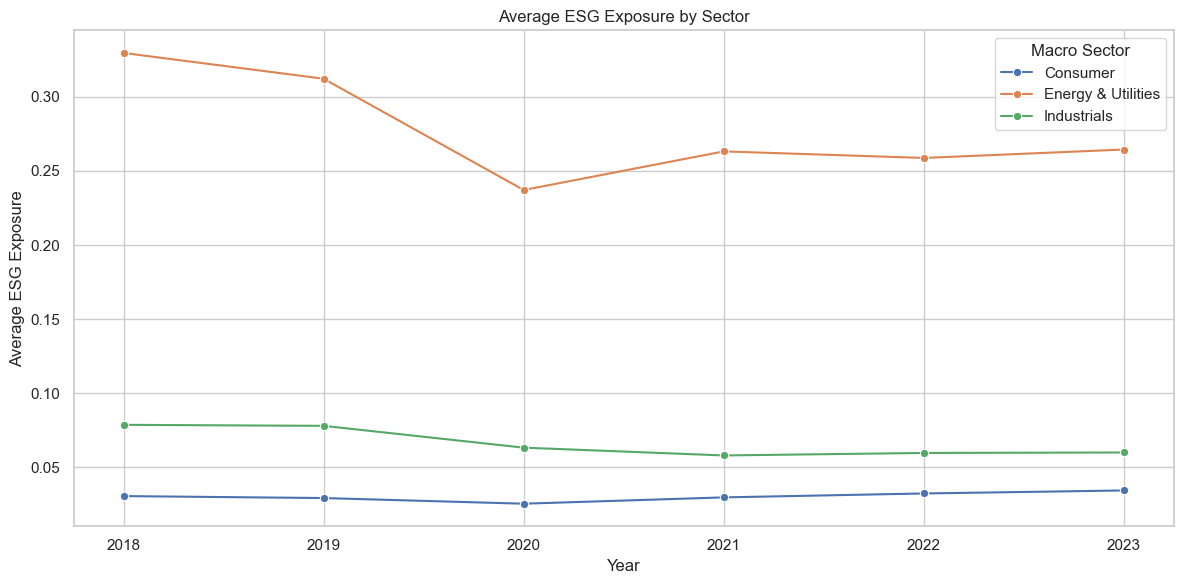

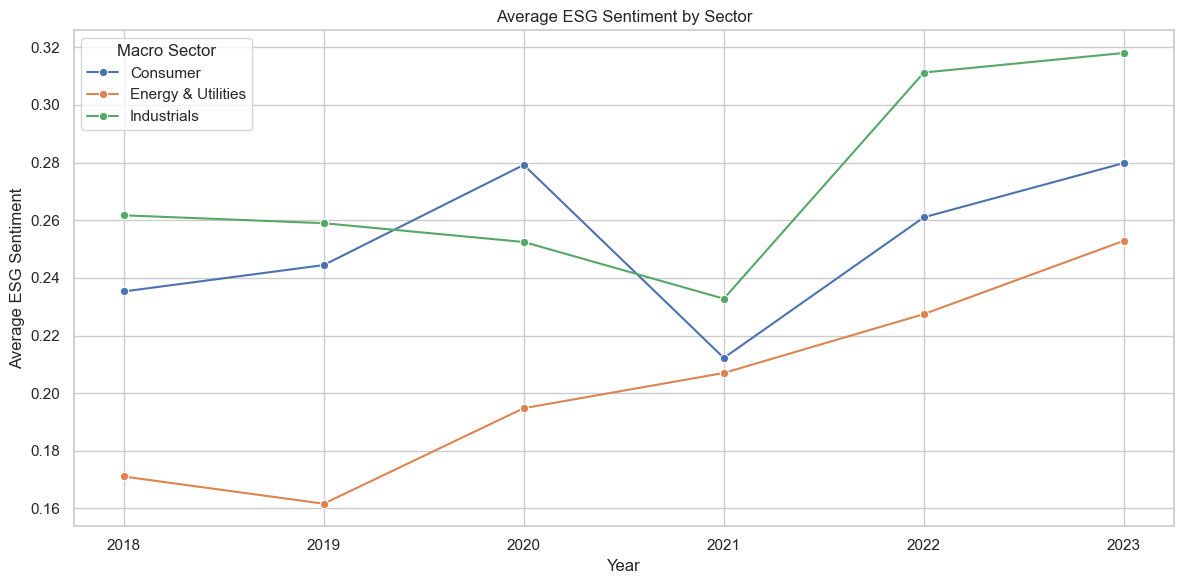

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set(style="whitegrid")

# plot for Overall ESG Expsoure
plt.figure(figsize=(12, 6))
sns.lineplot(data=macro_sector_means_climate, x='year', y='Overall_ESG_Exposure', hue='Macro_Sector', marker='o')
plt.title('Average ESG Exposure by Sector')
plt.xlabel('Year')
plt.ylabel('Average ESG Exposure')
plt.legend(title='Macro Sector')
plt.tight_layout()
plt.savefig("new_climate_avg_esg_exposure_by_sector.png")
plt.show()

# plot for Overall ESG Sentiment
plt.figure(figsize=(12, 6))
sns.lineplot(data=macro_sector_means_climate, x='year', y='Overall_ESG_Sentiment', hue='Macro_Sector', marker='o')
plt.title('Average ESG Sentiment by Sector')
plt.xlabel('Year')
plt.ylabel('Average ESG Sentiment')
plt.legend(title='Macro Sector')
plt.tight_layout()
plt.savefig("new_climate_avg_esg_sentiment_by_sector.png")
plt.show()
